In [1]:
"""
Grover's Search Benchmark Program - Qiskit
"""

import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = ["_common", "_common/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit"]
import execute as ex
import metrics as metrics


In [2]:
# Benchmark Name
benchmark_name = "Grover's Search"

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
grover_oracle = None
diffusion_operator = None
 
# for validating the implementation of an mcx shim  
_use_mcx_shim = False 

In [3]:

############### Circuit Definition

def GroversSearch(num_qubits, marked_item, n_iterations):

    # allocate qubits
    qr = QuantumRegister(num_qubits);
    cr = ClassicalRegister(num_qubits);
    qc = QuantumCircuit(qr, cr, name=f"grovers-{num_qubits}-{marked_item}")

    # Start with Hadamard on all qubits
    for i_qubit in range(num_qubits):
        qc.h(qr[i_qubit])

    # loop over the estimated number of iterations
    for _ in range(n_iterations):

        qc.barrier()
    
        # add the grover oracle
        qc.append(add_grover_oracle(num_qubits, marked_item).to_instruction(), qr)
        
        # add the diffusion operator
        qc.append(add_diffusion_operator(num_qubits).to_instruction(), qr)

    qc.barrier()
        
    # measure all qubits
    qc.measure(qr, cr)

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

In [4]:
############## Grover Oracle

def add_grover_oracle(num_qubits, marked_item):
    global grover_oracle
    
    marked_item_bits = format(marked_item, f"0{num_qubits}b")[::-1]

    qr = QuantumRegister(num_qubits); qc = QuantumCircuit(qr, name="oracle")

    for (q, bit) in enumerate(marked_item_bits):
        if not int(bit):
            qc.x(q)

    qc.h(num_qubits - 1)
    
    if _use_mcx_shim:
        add_mcx(qc, [x for x in range(num_qubits - 1)], num_qubits - 1)
    else:
        qc.mcx([x for x in range(num_qubits - 1)], num_qubits - 1)
        
    qc.h(num_qubits - 1)

    qc.barrier()

    for (q, bit) in enumerate(marked_item_bits):
        if not int(bit):
            qc.x(q)

    if grover_oracle == None or num_qubits <= 5:
        if num_qubits < 9: grover_oracle = qc
        
    return qc

In [5]:
############## Grover Diffusion Operator

def add_diffusion_operator(num_qubits):
    global diffusion_operator

    qr = QuantumRegister(num_qubits); qc = QuantumCircuit(qr, name="diffuser")

    for i_qubit in range(num_qubits):
        qc.h(qr[i_qubit])
    for i_qubit in range(num_qubits):
        qc.x(qr[i_qubit])
    qc.h(num_qubits - 1)
    
    if _use_mcx_shim:
        add_mcx(qc, [x for x in range(num_qubits - 1)], num_qubits - 1)
    else:
        qc.mcx([x for x in range(num_qubits - 1)], num_qubits - 1)
        
    qc.h(num_qubits - 1)

    qc.barrier()

    for i_qubit in range(num_qubits):
        qc.x(qr[i_qubit])
    for i_qubit in range(num_qubits):
        qc.h(qr[i_qubit])
        
    if diffusion_operator == None or num_qubits <= 5:
        if num_qubits < 9: diffusion_operator = qc
        
    return qc

In [6]:
############### MCX shim

# single cx / cu1 unit for mcx implementation
def add_cx_unit(qc, cxcu1_unit, controls, target):
    num_controls = len(controls)
    i_qubit = cxcu1_unit[1]
    j_qubit = cxcu1_unit[0]
    theta = cxcu1_unit[2]
    
    if j_qubit != None:
        qc.cx(controls[j_qubit], controls[i_qubit]) 
    qc.cu1(theta, controls[i_qubit], target)
        
    i_qubit = i_qubit - 1
    if j_qubit == None:
        j_qubit = i_qubit + 1
    else:
        j_qubit = j_qubit - 1
        
    if theta < 0:
        theta = -theta
    
    new_units = []
    if i_qubit >= 0:
        new_units += [ [ j_qubit, i_qubit, -theta ] ]
        new_units += [ [ num_controls - 1, i_qubit, theta ] ]
        
    return new_units

In [7]:
# mcx recursion loop 
def add_cxcu1_units(qc, cxcu1_units, controls, target):
    new_units = []
    for cxcu1_unit in cxcu1_units:
        new_units += add_cx_unit(qc, cxcu1_unit, controls, target)
    cxcu1_units.clear()
    return new_units

In [8]:
# mcx gate implementation: brute force and inefficent
# start with a single CU1 on last control and target
# and recursively expand for each additional control
def add_mcx(qc, controls, target):
    num_controls = len(controls)
    theta = np.pi / 2**num_controls
    qc.h(target)
    cxcu1_units = [ [ None, num_controls - 1, theta] ]
    while len(cxcu1_units) > 0:
        cxcu1_units += add_cxcu1_units(qc, cxcu1_units, controls, target)
    qc.h(target)

In [9]:
################ Analysis
  
# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, marked_item, num_shots):
    
    counts = result.get_counts(qc)
    if verbose: print(f"For type {marked_item} measured: {counts}")

    # we compare counts to analytical correct distribution
    correct_dist = grovers_dist(num_qubits, marked_item)
    if verbose: print(f"Marked item: {marked_item}, Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

def grovers_dist(num_qubits, marked_item):
    
    n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)
    
    dist = {}

    for i in range(2**num_qubits):
        key = bin(i)[2:].zfill(num_qubits)
        theta = np.arcsin(1/np.sqrt(2 ** num_qubits))
        
        if i == int(marked_item):
            dist[key] = np.sin((2*n_iterations+1)*theta)**2
        else:
            dist[key] = (np.cos((2*n_iterations+1)*theta)/(np.sqrt(2 ** num_qubits - 1)))**2
    return dist

In [10]:
################ Benchmark Loop

# Because this circuit size grows significantly with num_qubits (due to the mcx gate)
# limit the max_qubits here ...
MAX_QUBITS=8

# Execute program with default parameters
def run(min_qubits=2, max_qubits=6, skip_qubits=1, max_circuits=3, num_shots=100,
        use_mcx_shim=False,
        backend_id='qasm_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} Benchmark Program - Qiskit")

    # Clamp the maximum number of qubits
    if max_qubits > MAX_QUBITS:
        print(f"INFO: {benchmark_name} benchmark is limited to a maximum of {MAX_QUBITS} qubits.")
        max_qubits = MAX_QUBITS
        
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # create context identifier
    if context is None: context = f"{benchmark_name} Benchmark"
    
    # set the flag to use an mcx shim if given
    global _use_mcx_shim
    _use_mcx_shim = use_mcx_shim
    if _use_mcx_shim:
        print("... using MCX shim")
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, s_int, num_shots):

        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int), num_shots)
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()

            n_iterations = int(np.pi * np.sqrt(2 ** num_qubits) / 4)

            qc = GroversSearch(num_qubits, s_int, n_iterations)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time() - ts)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc2 = qc.decompose()
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc2, num_qubits, s_int, num_shots)
        
        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)
    
    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)
    
    ##########
    
    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nOracle ="); print(grover_oracle if grover_oracle!= None else "  ... too large!")
    print("\nDiffuser ="); print(diffusion_operator )

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} - Qiskit")


Grover's Search Benchmark Program - Qiskit
... execution starting at Nov 06, 2023 06:46:07 UTC
************
Executing [3] circuits with num_qubits = 2
************
Executing [3] circuits with num_qubits = 3
************
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 13, 0.116
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 13, 0.123, 2.0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.004, 0.546, 0.015 secs
Average Transpiling, Validating, Running Times for group 2 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 0.0, 0.0

************
Executing [3] circuits with num_qubits = 4
************
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 25, 0.083
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 51, 0.303, 24.0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.016, 1.335, 0.015 secs
Average Transpiling, Validating

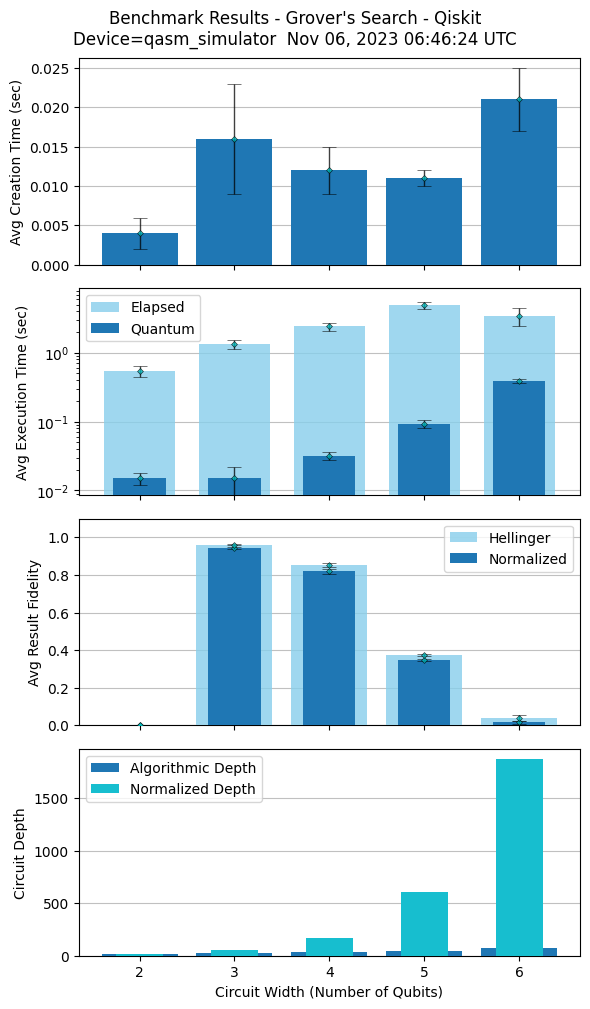

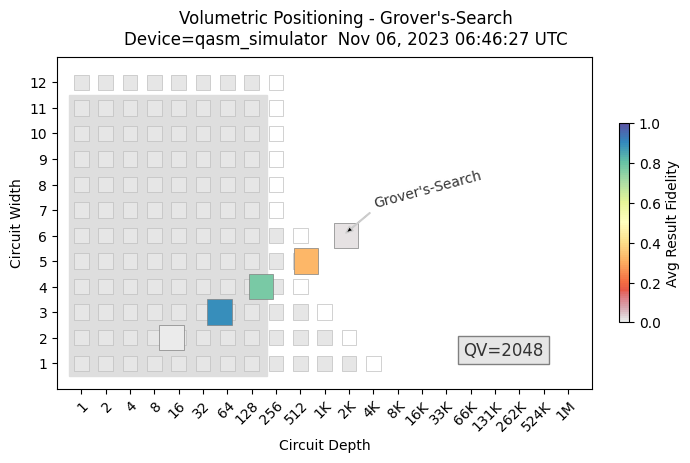

In [11]:
# if main, execute method
if __name__ == '__main__': run()